# Analisis de algoritmos de clasificación aplicados a Dataset

## Importamos librerias

In [205]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import StandardScaler
#Bibliotecas para generar gráficos
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
import pmdarima as pm
from pmdarima.model_selection import train_test_split

#import shap
#from pdpbox import pdp, get_dataset, info_plots
#import matplotlib.pyplot as plt

## Importamos el dataset

In [206]:
bipolar_interviews=pd.read_csv('./diario.csv', sep=';')

## Limpieza de datos

In [207]:
bipolar_interviews=bipolar_interviews.replace(to_replace="No", value=0)
bipolar_interviews=bipolar_interviews.replace(to_replace="Si", value=1)
bipolar_interviews=bipolar_interviews.replace(to_replace="NO", value=0)
bipolar_interviews=bipolar_interviews.replace(to_replace="no", value=0)
bipolar_interviews=bipolar_interviews.replace(to_replace="SI", value=1)

In [208]:
bipolar_interviews=bipolar_interviews.drop(columns=["Fecha","Hora de despertar","Hora a la que te dormiste","Ciclo menstrual"])

## Eliminamos valores de offset

In [209]:
#Calculamos limites de la distribucion de cafeina hasta 3 desviaciones estandar
mean_cafeina = bipolar_interviews.mean()[7]
std_cafeina = bipolar_interviews.std()[7]
lim_inf_caf = mean_cafeina - 3*std_cafeina
lim_sup_caf = mean_cafeina + 3*std_cafeina

#Calculamos limites de la distribución de cigarrillos hasta 3 desviaciones estandar
mean_cigarrillo=bipolar_interviews.mean()[6]
std_cigarrillo=bipolar_interviews.std()[6]
lim_inf_cig=mean_cigarrillo-3*std_cigarrillo
lim_sup_cig=mean_cigarrillo+3*std_cigarrillo

C:\Users\cris_\AppData\Local\Temp/ipykernel_19884/1727321591.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_cafeina = bipolar_interviews.mean()[7]
C:\Users\cris_\AppData\Local\Temp/ipykernel_19884/1727321591.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std_cafeina = bipolar_interviews.std()[7]
C:\Users\cris_\AppData\Local\Temp/ipykernel_19884/1727321591.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_cigarrillo=bipolar_interviews.mean()[6]
C:\Users\cris_\AppDa

In [210]:
bipolar_trimmed=bipolar_interviews[(bipolar_interviews["Cafeína"]>=lim_inf_caf)&(bipolar_interviews["Cafeína"]<=lim_sup_caf)&(bipolar_interviews["Número de cigarrillos"]>=lim_inf_cig)&(bipolar_interviews["Número de cigarrillos"]<=lim_sup_cig)]

In [211]:
bipolar_trimmed

,Estado de ánimo,Motivación,Problemas de concentración y atención,Irritabilidad,Ansiedad,Calidad del sueño,Número de cigarrillos,Cafeína,Alcohol,Otras drogas,Código,ID
0,2,2,3,3,3,3,34,150,0,0,D,1
1,2,2,3,3,3,3,38,150,0,0,D,1
2,2,1,3,3,3,3,39,120,0,0,D,1
3,1,2,2,2,2,3,34,120,0,0,D,1
4,1,1,3,2,2,2,32,150,0,0,D,1
...,...,...,...,...,...,...,...,...,...,...,...,...
679,2,3,0,0,1,0,0,90,0,1,G,1503864795
680,0,3,2,4,0,1,4,0,0,1,G,1503864795
681,0,0,1,4,0,2,0,0,0,0,G,1503864795
682,0,-1,2,3,2,3,0,90,0,0,G,1088011201


In [212]:
feature_cols = ['Estado de ánimo','Motivación','Problemas de concentración y atención','Irritabilidad','Ansiedad','Calidad del sueño','Número de cigarrillos','Cafeína']
X=bipolar_trimmed[feature_cols]

In [213]:
y=bipolar_trimmed['Código']

In [214]:

X_train,X_temp,y_train,y_temp = train_test_split(X,y,test_size=0.30)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [215]:
print(len(X_train),len(X_test),len(X_val))

476 102 102


In [216]:
X_train

,Estado de ánimo,Motivación,Problemas de concentración y atención,Irritabilidad,Ansiedad,Calidad del sueño,Número de cigarrillos,Cafeína
0,2,2,3,3,3,3,34,150
1,2,2,3,3,3,3,38,150
2,2,1,3,3,3,3,39,120
3,1,2,2,2,2,3,34,120
4,1,1,3,2,2,2,32,150
...,...,...,...,...,...,...,...,...
472,0,1,2,1,1,3,17,90
473,0,0,1,1,1,2,17,90
474,0,-1,2,1,1,2,17,90
475,0,-1,1,1,1,1,20,90


## a) SVM

In [217]:
modelo_svm = SVC(kernel='linear', C=1.0, random_state=42)

In [218]:
modelo_svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [219]:
y_val_preda = modelo_svm.predict(X_val)
y_preda=modelo_svm.predict(X_test)

In [220]:
# Calcular la precisión en el conjunto de validación
precision_val = accuracy_score(y_val, y_val_preda)
print("Precisión en el conjunto de validación:", precision_val)

Precisión en el conjunto de validación: 0.7549019607843137


In [221]:
# Exactitud
accuracy = accuracy_score(y_test,y_preda)
print("Exactitud:", accuracy)

# Precision
precision = precision_score(y_test, y_preda,average='macro')
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_preda,average='macro')
print("Recall:", recall)

# F1-score
f1 = f1_score(y_test, y_preda,average='macro')
print("F1-score:", f1)

Exactitud: 0.7745098039215687
Precision: 0.6576576576576577
Recall: 0.5505050505050505
F1-score: 0.5917640651836957


C:\Users\cris_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [222]:
c=confusion_matrix(y_test, y_preda, labels=['M', 'D', 'G'])
pd.DataFrame(c,index=['M', 'D', 'G'],columns=['M', 'D', 'G'])

,M,D,G
M,43,22,1
D,0,0,0
G,0,0,36


## b) Algoritmo de KNN

In [223]:
# Se hace un barrido para los distintos valores de K, evaluando la exactitud del algoritmo (o puntuación)
k_range = range(1,50)
scores = {}
scores_list = []
for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train,y_train)
        y_predb=knn.predict(X_test)
        scores[k] = metrics.accuracy_score(y_test,y_predb)
        
        scores_list.append(metrics.accuracy_score(y_test,y_predb))

Text(0, 0.5, 'Testing Accuracy')

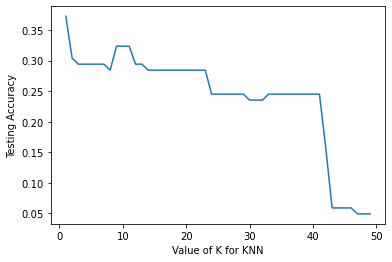

In [224]:
#Se grafica la relación entre K y su exactitud o puntuación
plt.plot(k_range,scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

## c) Algoritmo de Naive bayes

In [225]:
gnb = GaussianNB()
# Train classifier

gnb.fit(X_train,y_train)

GaussianNB()

In [226]:
y_val_pred = gnb.predict(X_val)
y_pred=gnb.predict(X_test)



In [227]:
# Calcular la precisión en el conjunto de validación
precision_val = accuracy_score(y_val, y_val_pred)
print("Precisión en el conjunto de validación:", precision_val)

Precisión en el conjunto de validación: 0.8725490196078431


In [228]:
# Excatitud
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy)

# Precision
precision = precision_score(y_test, y_pred,average='macro')
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred,average='macro')
print("Recall:", recall)

# F1-score
f1 = f1_score(y_test, y_pred,average='macro')
print("F1-score:", f1)

Precisión: 0.7352941176470589
Precision: 0.6281968622394154
Recall: 0.5134680134680134
F1-score: 0.5628660595955709


C:\Users\cris_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [229]:
c=confusion_matrix(y_test, y_pred, labels=['M', 'D', 'G'])
pd.DataFrame(c,index=['M', 'D', 'G'],columns=['M', 'D', 'G'])

,M,D,G
M,43,22,1
D,0,0,0
G,4,0,32


## d) Random Forest

In [230]:
rf = RandomForestClassifier(n_jobs=-1)

rf.fit(X_train, y_train)

y_val_pred = rf.predict(X_val)
y_pred=rf.predict(X_test)

scores = cross_val_score(rf, X_test, y_pred, cv=2)

print("Precisión del modelo: ", scores.mean())

Precisión del modelo:  0.7254901960784315


In [231]:
precision_val = accuracy_score(y_val, y_val_pred)
print("Precisión en el conjunto de validación:", precision_val)

Precisión en el conjunto de validación: 0.8333333333333334


In [232]:
# Exactitud
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy)

# Precision
precision = precision_score(y_test, y_pred,average='macro')
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred,average='macro')
print("Recall:", recall)

# F1-score
f1 = f1_score(y_test, y_pred,average='macro')
print("F1-score:", f1)

Precisión: 0.7254901960784313
Precision: 0.649074074074074
Recall: 0.5210437710437711
F1-score: 0.5693570929419987


C:\Users\cris_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [233]:
c=confusion_matrix(y_test, y_pred, labels=['M', 'D', 'G'])
pd.DataFrame(c,index=['M', 'D', 'G'],columns=['M', 'D', 'G'])

,M,D,G
M,39,26,1
D,0,0,0
G,1,0,35


In [234]:
import time

In [235]:
start_time = time.time()
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

In [236]:
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.033 seconds


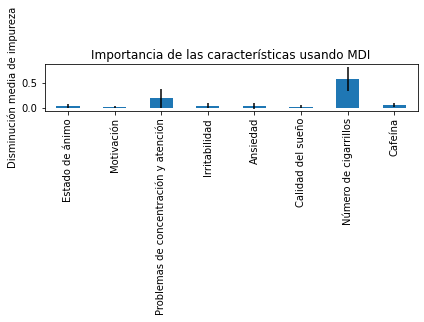

In [237]:
forest_importances = pd.Series(importances, index=feature_cols)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Importancia de las características usando MDI")
ax.set_ylabel("Disminución media de impureza")
fig.tight_layout()

In [238]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
        rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_cols)

Elapsed time to compute the importances: 6.306 seconds


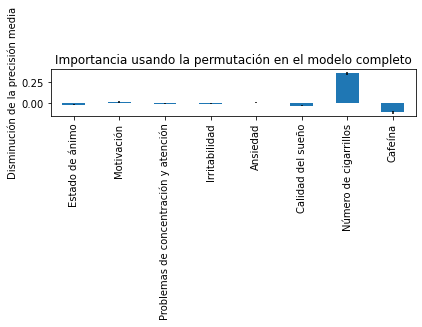

In [239]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Importancia usando la permutación en el modelo completo")
ax.set_ylabel("Disminución de la precisión media")
fig.tight_layout()

plt.show()

## e) Arbol de decisión

In [240]:
dt = DecisionTreeClassifier(criterion= 'entropy', max_depth= None, min_samples_leaf= 1, min_samples_split= 2)



# Realiza la búsqueda de hiperparámetros en el conjunto de entrenamiento
dt.fit(X_train, y_train)
# Muestra los mejores hiperparámetros encontrados


scores = cross_val_score(dt, X_test, y_test)
print("Exactitud del modelo:", scores.mean())

Exactitud del modelo: 0.9804761904761905


In [190]:
y_val_pred = dt.predict(X_val)
y_pred=dt.predict(X_test)

In [191]:
# Exactitud
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy)

# Precision
precision = precision_score(y_test, y_pred,average='macro')
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred,average='macro')
print("Recall:", recall)

# F1-score
f1 = f1_score(y_test, y_pred,average='macro')
print("F1-score:", f1)

Precisión: 0.696078431372549
Precision: 0.6576576576576577
Recall: 0.51010101010101
F1-score: 0.5597902255979023


C:\Users\cris_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [192]:
c=confusion_matrix(y_test, y_pred, labels=['M', 'D', 'G'])
pd.DataFrame(c,index=['M', 'D', 'G'],columns=['M', 'D', 'G'])

,M,D,G
M,35,30,1
D,0,0,0
G,0,0,36


## f) gradient Boosting

In [193]:
gb_model = GradientBoostingClassifier(n_estimators=200,learning_rate=0.2,max_depth=5,min_samples_split=5,subsample=0.8)

In [194]:
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_depth=5, min_samples_split=5,
                           n_estimators=200, subsample=0.8)

In [195]:
y_pred = gb_model.predict(X_test)
y_val_pred = gb_model.predict(X_val)


In [196]:
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo:", accuracy)

Precisión del modelo: 0.696078431372549


In [197]:
# Exactitud
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy)

# Precision
precision = precision_score(y_test, y_pred,average='macro')
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred,average='macro')
print("Recall:", recall)

# F1-score
f1 = f1_score(y_test, y_pred,average='macro')
print("F1-score:", f1)

Precisión: 0.696078431372549
Precision: 0.6576576576576577
Recall: 0.51010101010101
F1-score: 0.5597902255979023


C:\Users\cris_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [198]:
c=confusion_matrix(y_test, y_pred, labels=['M', 'D', 'G'])
pd.DataFrame(c,index=['M', 'D', 'G'],columns=['M', 'D', 'G'])

,M,D,G
M,35,30,1
D,0,0,0
G,0,0,36


In [199]:
#X_train,X_temp,y_train,y_temp = train_test_split(X,y,test_size=0.20, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Utilización del algoritmo de cada paciente para predicción de estado de ánimo

In [200]:
paciente_ids = bipolar_trimmed['ID'].unique()


In [201]:
for paciente_id in [1,2,3,1503864795]:
    # Filtra el DataFrame por ID de paciente
    paciente_df = bipolar_trimmed[bipolar_trimmed['ID'] == paciente_id]

    # Separa las características (X) y la variable objetivo (y)
    X = paciente_df.drop(columns=["Estado de ánimo","Código"])  # Ajusta el nombre de la columna según tu conjunto de datos
    y = paciente_df["Estado de ánimo"]
    
    # Divide el conjunto de datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    print(f'***************************************************************************')
# Define una lista de modelos
    modelos = [
        ('Arbol de desicion', DecisionTreeClassifier()),
        ('SVM', SVC()),
        ('Random Forest', RandomForestClassifier()),
        ('Gradient Boosting', GradientBoostingClassifier()),
        ('Naive bayes', GaussianNB()),
        ('KNN',KNeighborsClassifier(n_neighbors=20))
        
        # Agrega más modelos según sea necesario
    ]

    # Itera sobre cada modelo
    for nombre_modelo, modelo in modelos:
        # Entrena el modelo
        modelo.fit(X_train, y_train)

        # Realiza predicciones en el conjunto de prueba
        y_pred = modelo.predict(X_test)

        # Evalúa la precisión del modelo
        accuracy = accuracy_score(y_test, y_pred)
        # Precision
        precision = precision_score(y_test, y_pred,average='macro',zero_division=1)

        # Recall
        recall = recall_score(y_test, y_pred,average='macro',zero_division=1)

        # F1-score
        f1 = f1_score(y_test, y_pred,average='macro')

        # Imprime la precisión para cada paciente y modelo
        print(f'ID_Paciente: {paciente_id}, Modelo: {nombre_modelo},\n                Precisión: {accuracy}, \n                Recall:{recall}, \n                f1 score:{f1}')
        
        

***************************************************************************
ID_Paciente: 1, Modelo: Arbol de desicion,
                Precisión: 0.34615384615384615, 
                Recall:0.507090909090909, 
                f1 score:0.32727272727272727
ID_Paciente: 1, Modelo: SVM,
                Precisión: 0.21153846153846154, 
                Recall:0.25, 
                f1 score:0.08730158730158731
ID_Paciente: 1, Modelo: Random Forest,
                Precisión: 0.5769230769230769, 
                Recall:0.5165909090909091, 
                f1 score:0.5169713718820862
ID_Paciente: 1, Modelo: Gradient Boosting,
                Precisión: 0.5384615384615384, 
                Recall:0.5263636363636364, 
                f1 score:0.5577922077922077
ID_Paciente: 1, Modelo: Naive bayes,
                Precisión: 0.6538461538461539, 
                Recall:0.6554545454545455, 
                f1 score:0.4386361441128175
ID_Paciente: 1, Modelo: KNN,
                Precisión: 0.442307

Elapsed time to compute the importances: 1.405 seconds


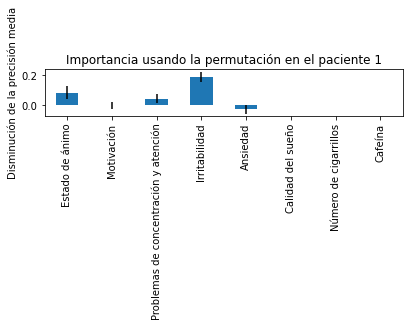

Elapsed time to compute the importances: 1.197 seconds


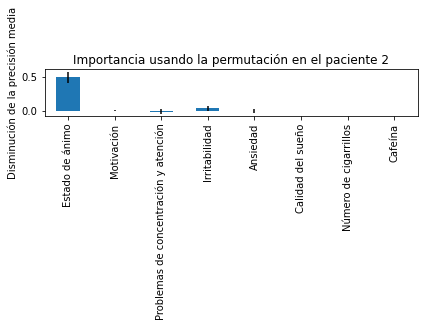

Elapsed time to compute the importances: 1.183 seconds


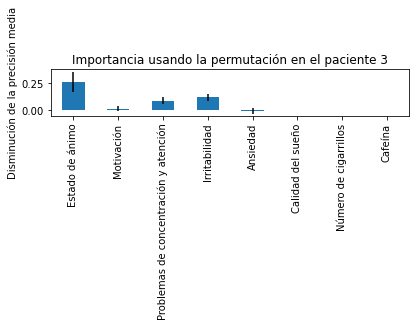

Elapsed time to compute the importances: 1.187 seconds


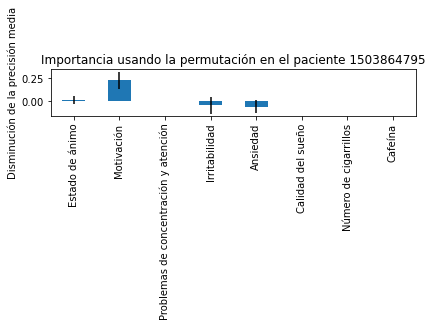

In [299]:
for paciente_id in [1,2,3,1503864795]:
    paciente_df = bipolar_trimmed[bipolar_trimmed['ID'] == paciente_id]

    # Separa las características (X) y la variable objetivo (y)
    X = paciente_df.drop(columns=["Estado de ánimo","Código","Número de cigarrillos","Cafeína"])  
    # Ajusta el nombre de la columna según tu conjunto de datos
    y = paciente_df["Estado de ánimo"]
    
    # Divide el conjunto de datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    rf=RandomForestClassifier()
    rf.fit(X_train, y_train)
    from sklearn.inspection import permutation_importance

    start_time = time.time()
    result = permutation_importance(
        rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
    )
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

    forest_importances = pd.Series(result.importances_mean, index=feature_columns)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title(f"Importancia usando la permutación en el paciente {paciente_id}")
    ax.set_ylabel("Disminución de la precisión media")
    fig.tight_layout()

    plt.show()

In [281]:
    rf=RandomForestClassifier()

In [287]:
    rf.fit(X_train, y_train)

RandomForestClassifier()

In [291]:
    from sklearn.inspection import permutation_importance

    start_time = time.time()
    result = permutation_importance(
        rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
    )
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

    forest_importances = pd.Series(result.importances_mean, index=feature_columns)

Elapsed time to compute the importances: 1.656 seconds


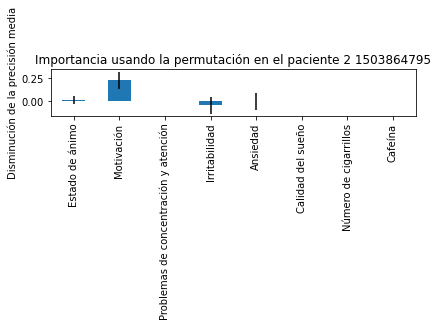

In [298]:
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title(f"Importancia usando la permutación en el paciente  {paciente_id}")
    ax.set_ylabel("Disminución de la precisión media")
    fig.tight_layout()

    plt.show()